
# Tinkoff sirius ML 2023 RecSys intro task (Модели)

❗ Чтобы код, приведенный работал корректно необходимо, чтобы были featured данные. Их можно получить либо в репозитории, либо запустить EDA.ipynb и они сгенерурются сами.

### Бибилиотеки, данные, метрики, класс для наследования

In [1]:
!pip install implicit >> /dev/null

In [45]:
from abc import ABC, abstractmethod
from typing import Dict, List
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import implicit
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid, train_test_split

In [3]:
data_folder = 'kion_data_featured/'

users_df = pd.read_csv(data_folder + 'users.csv')
items_df = pd.read_csv(data_folder + 'items.csv')
train_part = pd.read_csv(data_folder + 'train.csv', parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + 'test_data.csv')
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()

In [4]:
 # https://github.com/deethereal/tinkoff-sirius-ml-2023-recsys-intro-task/blob/main/intro_task.ipynb
 # ACHTUNG! DO NOT TOUCH

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

In [5]:
# https://github.com/deethereal/tinkoff-sirius-ml-2023-recsys-intro-task/blob/main/intro_task.ipynb
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из item_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

## Cтатистически подходы

### Топ популярных (Baseline)

In [6]:
# https://github.com/deethereal/tinkoff-sirius-ml-2023-recsys-intro-task/blob/main/intro_task.ipynb
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")

{'ndcg': 0.17037237918248196, 'recall': 0.0763696799665908}

### Топ популярных для разных категорий

Во время EDA мы выделили новые признаки для фильмов, а именно: какого пола человека чаще проссматривает фильм, какого возраста и дохода. Эти признаки будем использовать для рекомендаций. Для пользователей, про которых мы ничего не знаем (они есть в train_part, но их нет в users_df) - будем рекомендовать популярные.

In [7]:
class CategoryTopPopularRecommender(BaseRecommender):
    def __init__(self, category: str):
        super().__init__()
        self.cat_popularity = None
        self.trained = False
        self.top_popular_items = None
        self.category = category

    def fit(self, train_part: pd.DataFrame, users_df: pd.DataFrame, items_df: pd.DataFrame,
            item_id_col = 'item_id', views_col = 'views', user_id_col='user_id'):
        # Вычисляем общий список популярных фильмов по все значениям категории
        self.top_popular_items = items_df[[item_id_col, views_col]]\
                                  .sort_values(views_col, ascending=False)[item_id_col].to_list()

        # Группируем 'items_df' по категории и сортируем фильмы по популярности (колонка 'views')
        self.cat_popularity = dict(train_part.merge(users_df, how='left', on=user_id_col)[[self.category, item_id_col]]\
                                   .groupby(self.category)[item_id_col]\
                                   .apply(lambda x: x.value_counts().index.tolist()))


        self.trained = True

    def predict(self, test_part: pd.DataFrame, users_df: pd.DataFrame, user_id_col = 'user_id', topn=10):
        assert self.trained

        # Объединяем 'test_part' с 'users_df' по 'user_id' и оставляем только 'user_id' и категорию
        user_data = users_df[[user_id_col, self.category]]
        test_data = test_part.merge(user_data, on='user_id', how='left')

        # Создаем пустой столбец 'recommendations' для хранения рекомендаций
        test_data['recommendations'] = None

        # Для каждой строки в test_data вычисляем рекомендации
        for index, row in test_data.iterrows():
            cat = row[self.category]
            if cat in self.cat_popularity:
                recommendations = self.cat_popularity[cat][:topn]
            # Если мы ничего не знаем про пользователя, то рекомендуем популярное
            else:
                recommendations = self.top_popular_items[:topn]

            test_data.at[index, 'recommendations'] = recommendations

        # Возвращаем столбец 'recommendations' с рекомендациями
        return test_data['recommendations']

for cat in ['sex', 'income', 'age']:
    recommender = CategoryTopPopularRecommender(cat)
    recommender.fit(train_part, users_df, items_df)
    test_part[cat + "_recs"] = recommender.predict(test_part, users_df)
    print(f'Разибение по {cat}: ', evaluate_recommender(df=test_part, model_preds_col=cat + "_recs"))

Разибение по sex:  {'ndcg': 0.1712007695565208, 'recall': 0.07668173604995636}
Разибение по income:  {'ndcg': 0.17148589785741739, 'recall': 0.07695524790918498}
Разибение по age:  {'ndcg': 0.17224145285241338, 'recall': 0.07724899822276024}


Видим, что разбиение по категориям работает немного лучше, чем бейзлайн.

## Классические методы (Implicit)



Создадим класс для работы с implicit, для того чтбы не повторять код. От него будем создавать все implicit модели.

In [8]:
# https://github.com/deethereal/tinkoff-sirius-ml-2023-recsys-intro-task/blob/main/intro_task.ipynb

# Изначально я написал свою реализацию класса, она получилось сложной и запутанной,
# поэтому решил позаимствовать реализвацию из условия задания

class ImplicitBaseRecommender(BaseRecommender):
    def __init__(self, model=None, **kwargs) -> None:
        super().__init__()
        self.params = kwargs
        self.model = model(**kwargs)
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

    # Метод, который возвращает df для модели второго уровня
    def get_df_recs(self, df: pd.DataFrame, topn: int = 50,
                    user_id_col: str ='user_id', item_id_col: str = 'item_id'
    ) -> pd.DataFrame:
        assert self.trained

        df['recs'] = self.predict(first_level_test, topn)
        df = df.explode('recs', ignore_index=True)
        df['rank'] = df.groupby([user_id_col, item_id_col]).cumcount() + 1
        return df

    # два метода, чтобы правильно работал подбор гиппер параматеров через кроссвалидацию из sklearn
    # https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html
    # В итоге было принято решение отказаться от подбора гиперпараметров c помощью k-fold cv подробнее ниже
    def set_params(self, **params):
        self.model = self.model(**params)
        return self

    def get_params(self, deep=True):
        return {**self.params}

### kNN

In [9]:
knn_rec = ImplicitBaseRecommender(model=implicit.nearest_neighbours.CosineRecommender,
                                  K=15_000)
knn_rec.fit(train_part)
test_part["knn_recs"] = knn_rec.predict(test_part)

/home/gr/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011188983917236328 seconds
  warnings.warn(


  0%|          | 0/12067 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [10]:
evaluate_recommender(test_part, model_preds_col="knn_recs")

{'ndcg': 0.12234769080835413, 'recall': 0.054391934978456756}

Видим, что качество просело даже по сравнению с бейзлайном.

### TFIDF

In [11]:
tfidf_rec = ImplicitBaseRecommender(model=implicit.nearest_neighbours.TFIDFRecommender,
                                    K=15_000)
tfidf_rec.fit(train_part)
test_part["tfidf_recs"] = tfidf_rec.predict(test_part)

/home/gr/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.01186370849609375 seconds
  warnings.warn(


  0%|          | 0/12067 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [12]:
evaluate_recommender(test_part, model_preds_col="tfidf_recs")

{'ndcg': 0.12740156038704564, 'recall': 0.05658684677730701}

Аналогичная картина.

### Item to item

In [13]:
itemitem_rec = ImplicitBaseRecommender(model=implicit.nearest_neighbours.ItemItemRecommender,
                                       K=15_000)
itemitem_rec.fit(train_part)
test_part["itemitem_recs"] = itemitem_rec.predict(test_part)

  0%|          | 0/12067 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [14]:
evaluate_recommender(test_part, model_preds_col="itemitem_recs")

{'ndcg': 0.191239213767931, 'recall': 0.08579517402016573}

Item to Item сработал уже лучше, чем разделение на категории. Но и этот результат попробуем улучшить.

## Более сложные модели и их тюнинг

В ALS (и в моделях рассмотренных дальше) уже много параметров, и простое увеличение этих параметров не приведет к увеличению качества (как было с количеством соседей). Поэтому нам нужно использовать кросс-валидацию для подбора этих параметров.

Далее я столкнулся с проблемой: если использовать k-fold кросс-валидацию, то слишком много данных будет в тестовой часте, как следствие, модель не сможет хорошо обучиться. Эту проблему можно решить, если использовать большое количество фолдов, либо вообще leave-one-out, но у меня нет таких мощностей. *(По моим подсчетам на 50 фолдов и 25 наборов параметров нужно примерно 8 часов с использованием gpu)*

Будем использовать просто Hold-out валидацию на тестовой выборке.

---
https://datascience.stackexchange.com/questions/6814/how-to-split-train-test-in-recommender-systems

https://academy.yandex.ru/handbook/ml/article/kross-validaciya

https://github.com/anamarina/RecSys_course



Будем использовать gpu, это сэкономит кучу времени. Проверим cuda. (Позже я перезапускал ноутбук не в колабе, а на своем компьютере, в котором нет видеокарты)

In [15]:
!nvidia-smi

fish: Unknown command: nvidia-smi
fish: 
nvidia-smi
^~~~~~~~~^


Реализуем функцию для валидации параметров, использующую Hold Out валидацию.

In [28]:
# https://tqdm.github.io/
# https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d/sklearn/model_selection/_search.py#L50

# Про реализованную функцию len() узнал из исходного кода, в документации про неё ничего нет
# функцию len() вызывает tqdm
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html#sklearn.model_selection.ParameterGrid

def ImplicitHoldOutCV(model: ImplicitBaseRecommender,
              train_part: pd.DataFrame, test_part: pd.DataFrame,
              params: dict) -> tuple :
    param_grid = ParameterGrid(params)

    best_model = None
    best_params: dict = None
    best_score: dict[str, int] = {'ndcg': 0, 'recall': 0}

    for params in tqdm(param_grid):
        rec_model = ImplicitBaseRecommender(model=model, **params)
        rec_model.fit(train_part)
        test_part["recs"] = rec_model.predict(test_part)
        score = evaluate_recommender(test_part, model_preds_col="recs")
        if score['ndcg'] > best_score['ndcg'] \
                and score['recall'] > best_score['recall']:
            best_score = score
            best_model = rec_model
            best_params = params

    return best_model, best_params, best_score

Выделим валидационную выборку. 80% исходной тестовой выборки пойдут в трейн, 20% в тест. В тесте так же выберем только тех, пользователей, которые встречались ранее и у которых больше 2 просмотров.

In [29]:
train_part = train_part.sample(frac=1).reset_index(drop=True)


train_part_v = train_part.iloc[int(len(train_part) / 5):]


test_part_v = train_part.iloc[:int(len(train_part) / 5)]

# Оставим только тех пользователей, которые были в трейне
test_part_v = test_part_v[test_part_v['user_id'].isin(train_part_v['user_id'].unique())]

test_part_v = test_part_v[['user_id', 'item_id']]
test_part_v = test_part_v.groupby('user_id', as_index=False).agg(list)

# Оставим только пользователей с более, чем 2 взаимодействиями
test_part_v = test_part_v[test_part_v['item_id'].apply(len) > 2]
test_part_v = test_part_v.rename(columns={'item_id':'ground_truth'})

### ALS

In [30]:
# Параметры, которые использовались изначально
# params = {
#         'factors': [1, 2, 3],
#         'regularization': [0.01, 0.02],
#         'alpha': [0.1, 0.075, 0.125],
#         'iterations': [1, 2, 5, 10, 15],
#         'random_state': [42]
# }


# Лучшие параметры
params = {
    'alpha': [0.001],
    'factors': [1],
    'iterations': [5],
    'random_state': [42],
    'regularization': [0.01]
}

# model = implicit.gpu.als.AlternatingLeastSquares
model = implicit.cpu.als.AlternatingLeastSquares

best_als_model, best_als_params, best_als_score = ImplicitHoldOutCV(model,
                                                                train_part_v,
                                                                test_part_v,
                                                                params)

# Обучаем лучшую модель уже на всех данных
best_als_model = ImplicitBaseRecommender(model, **best_als_params)
best_als_model.fit(train_part)
test_part["als_recs"] = best_als_model.predict(test_part)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

predicting:   0%|          | 0/15840 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [31]:
evaluate_recommender(test_part, model_preds_col="als_recs")

{'ndcg': 0.18147419856444427, 'recall': 0.0822750659878154}

Item to item мы не превзошли, но лучше чем бейзлайн и топ популярных по категориям.

### BPR


In [32]:
# Параметры, которые использовались изначально
# params = {
#         'factors': [100, 300, 400, 600],
#         'regularization': [0.01, 0.02, 0.05, 0.075],
#         'learning_rate': [0.001, 0.01, 0.075],
#         'iterations': [10, 25, 30, 40],
#         'random_state': [42]
# }


# Лучшие параметры
params = {
         'factors': [400],
         'iterations': [10],
         'learning_rate': [0.001],
         'random_state': [42],
         'regularization': [0.05]
}

# model = implicit.gpu.bpr.BayesianPersonalizedRanking
model = implicit.cpu.bpr.BayesianPersonalizedRanking

best_bpr_model, best_bpr_params, best_bpr_score = ImplicitHoldOutCV(model,
                                                                train_part_v,
                                                                test_part_v,
                                                                params)

# Обучаем лучшую модель уже на всех данных
best_bpr_model = ImplicitBaseRecommender(model, **best_bpr_params)
best_bpr_model.fit(train_part)
test_part["bpr_recs"] = best_bpr_model.predict(test_part)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

predicting:   0%|          | 0/15840 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [33]:
evaluate_recommender(test_part, model_preds_col="bpr_recs")

{'ndcg': 0.06347402724046615, 'recall': 0.02499264789262535}

Плохое качество.

### LMF

In [34]:
# Параметры, которые использовались изначально
# params = {
#         'factors': [30, 40, 50, 70, 80],
#         'regularization': [0.1, 0.2, 0.5, 0.75, 1],
#         'learning_rate': [0.001, 0.01, 0.075, 0.125],
#         'iterations': [40, 50, 80, 100],
#         'neg_prop' : [5, 10, 30, 50],
#         'random_state': [42]
# }


# Лучшие параметры
params = {'factors': [40],
         'iterations': [300],
         'learning_rate': [0.3],
         'neg_prop': [5],
         'random_state': [42],
         'regularization': [1]
}

model = implicit.cpu.lmf.LogisticMatrixFactorization

best_lmf_model, best_lmf_params, best_lmf_score = ImplicitHoldOutCV(model,
                                                                train_part_v,
                                                                test_part_v,
                                                                params)

# Обучаем лучшую модель уже на всех данных
best_lmf_model = ImplicitBaseRecommender(model, **best_bpr_params)
best_lmf_model.fit(train_part)
test_part["lmf_recs"] = best_lmf_model.predict(test_part)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

predicting:   0%|          | 0/15840 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

In [35]:
evaluate_recommender(test_part, model_preds_col="lmf_recs")

{'ndcg': 0.0023001168495965034, 'recall': 0.000791875314423862}

Долго ждать предсказания, да и качество просто ужасное.

## EDA рекомендаций

Давайте посмотрим на то, как росли метрики в зависимости от модели.

In [36]:
columns = test_part.columns.to_list()[2:]
metrics = [evaluate_recommender(test_part, model_preds_col=pred_col) for pred_col in columns]

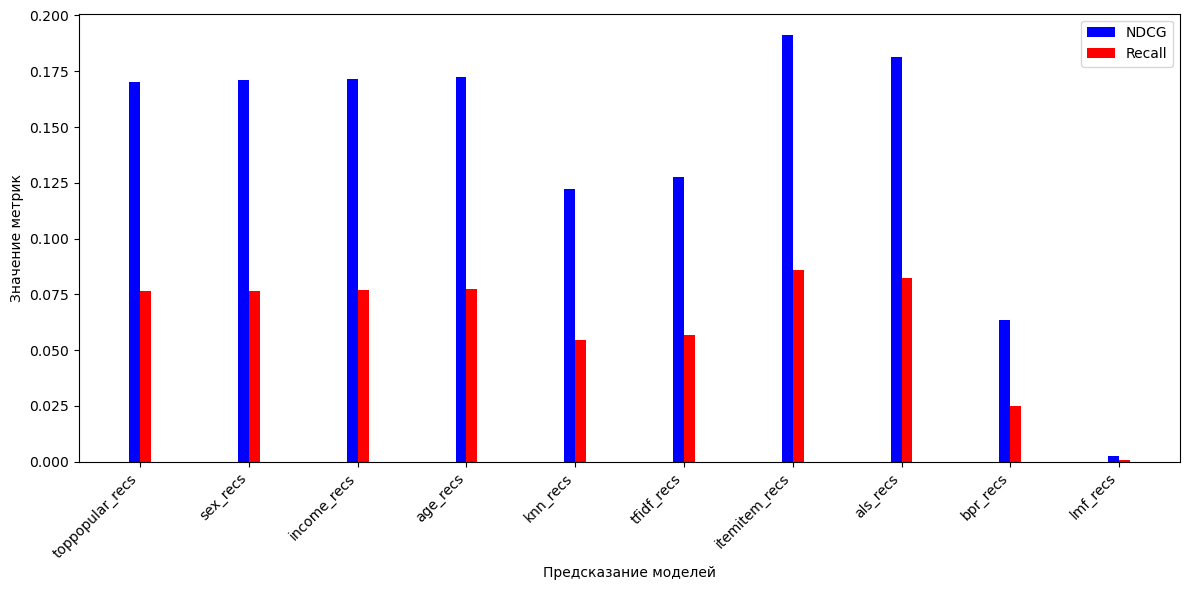

In [37]:
ndcg_values = [metric['ndcg'] for metric in metrics]
recall_values = [metric['recall'] for metric in metrics]

x = np.arange(len(columns))

bar_width = 0.1

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - bar_width/2, ndcg_values, 0.1, label='NDCG', color='blue')
ax.bar(x + bar_width/2, recall_values, bar_width, label='Recall', color='red')

ax.set_xticks(x)
ax.set_xticklabels(columns, rotation=45, ha='right')
ax.set_xlabel('Предсказание моделей')
ax.set_ylabel('Значение метрик')
ax.legend()
plt.tight_layout()
plt.show()

Видим, что лучшая модель это item to item, следующая als.

Давайте посморим, что нам рекомендует лучшая модель. А именно самые часто встречаемые фильмы встречаемый фильм.

In [38]:
top_item_item_recs = test_part['als_recs'].explode('als_recs').value_counts().keys().to_list()[:10]
top_items_als = items_df.loc[items_df['item_id'].isin(top_item_item_recs)]['title']
top_items_als

158                             Афера
572                   Клиника счастья
1429                      Хрустальный
4809                Гнев человеческий
4921                         Девятаев
5064           Секреты семейной жизни
5522                            Немцы
9137     Прабабушка легкого поведения
10305                      Подслушано
11506                            Маша
Name: title, dtype: object

Теперь посмотрим на топ популяных.

In [39]:
items_df.sort_values('views', ascending=False)['title'][:10]

1429                      Хрустальный
572                   Клиника счастья
4921                         Девятаев
4809                Гнев человеческий
5064           Секреты семейной жизни
10305                      Подслушано
9137     Прабабушка легкого поведения
158                             Афера
11506                            Маша
2939                            Дуров
Name: title, dtype: object

Видим, что получаенная модель рекомендует популярные фильмы, но в другом порядке.


Посмотрим, что рекомендуется к трем самым популярным фильмам.

In [40]:
print(f'К фильму: "{top_items_als.tolist()[0]}" Рекомендуется:', '\n')
similar_items = best_als_model.model.similar_items(top_item_item_recs[0], 5)[0].tolist()
items_df.loc[items_df['item_id'].isin(similar_items)]['title']

К фильму: "Афера" Рекомендуется: 



3452          Муми-дол
7795     Порожний рейс
10386        Портфолио
Name: title, dtype: object

In [41]:
print(f'К фильму: "{top_items_als.tolist()[1]}" Рекомендуется:', '\n')
similar_items = best_als_model.model.similar_items(top_item_item_recs[1], 5)[0].tolist()
items_df.loc[items_df['item_id'].isin(similar_items)]['title']

К фильму: "Клиника счастья" Рекомендуется: 



3124                    Три дня на побег
7284         Эспен в королевстве троллей
11203    Влюблен по собственному желанию
11522              Главное – не бояться!
Name: title, dtype: object

In [42]:
print(f'К фильму: "{top_items_als.tolist()[2]}" Рекомендуется:', '\n')
similar_items = best_als_model.model.similar_items(top_item_item_recs[2], 5)[0].tolist()
items_df.loc[items_df['item_id'].isin(similar_items)]['title']

К фильму: "Хрустальный" Рекомендуется: 



985      Нильский крокодил. Южная Африка
1505                              Феникс
6376                          Корпоратив
7979               257 причин чтобы жить
10255              Как раз под Рождество
Name: title, dtype: object

Фильмы не повторяются - это хорошо. Наша модель не склонна рекомендовать только популярное.

## Итог

1. Исследованы модели на основе простых разибений и на основе классических методов из implicit.
2. Лучшее качество получилось для item-item модели `ndcg: 0.191`, `recall: 0.086`.


Очень хотел, но не успел 😞 реаилзовать модель на основе бустинга и двухэтапную модель. На первом уровне лучшая модель из простых, в моем случае это item to item, на втором catboost, который использует предсказания первой модели, как фичи. Именно для этого я накрутил фичей и обучал такое количество простых моделей.

## Сохранение моделей

Сохраним лучшую модель.

In [46]:
model_filename = "itemitem.pkl"

with open(model_filename, 'wb') as model_file:
    pickle.dump(itemitem_rec, model_file)

Сохраним als модель, она вторая по качеству.

In [47]:
model_filename = "als.pkl"

with open(model_filename, 'wb') as model_file:
    pickle.dump(best_als_model, model_file)